
# Исследование поведения пользователей мобильного приложения
<br>


**Описание проекта**<br>

Мы работаем в стартапе, который продаёт продукты питания. <br>
Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 

*Для этого изучим воронку продаж и узнаем:*<br> 
 - как пользователи доходят до покупки,<br>
 - сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах,<br>
 - на каких именно?

*После исследуем результаты A/A/B-эксперимента.* <br>

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. <br>
Договорились принять решение по результатам A/A/B-теста.<br>

Пользователей разделим на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. <br>
Выясним, какой шрифт лучше.


**Итак, общий план исследования:**

1. Обзор данных,
2. Предобработка данных,
3. Изучение данных,
4. Изучение воронки событий,
5. Анализ результатов А/А/В-теста, принятие решения по по дальнейшим действиям,
6. Общий вывод по результатам исследования.

### Обзор данных

In [1]:
# Импортируем нужные библиотеки для чтения файлов, построения графиков и проведения расчетов

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math as mth
import seaborn as sns
from scipy import stats as st
from datetime import timedelta
import datetime as dt
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим файл
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
pd.options.display.max_colwidth = 150  

# Чтобы отображались все столбцы, добавим настройку
pd.set_option('display.max_columns', None)

df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
# Изучим общую информацию о файле
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод по обзору данных**<br>

Пока видим следующее:

 - В датасете 4 столбца - логи действий пользователей.<br>
 Каждая запись в логе — это действие пользователя, или событие: 
   - EventName — название события;
   - DeviceIDHash — уникальный идентификатор пользователя;
   - EventTimestamp — время события;
   - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.<br>


 - пропусков нет,
 - необходимо привести столбцы к нижнему регистру,
 - необходимо привести столбец со временем события EventTimestamp к корректному формату.
<br>

Кроме того, добавим столбец даты и времени, а также отдельный столбец дат.

### Предобработка данных

In [4]:
# Заменим названия столбцов, проверим результат
df.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
df.columns

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

In [5]:
# Скорректируем тип данных в столбце с временем
df['event_timestamp'] = df['event_timestamp'].astype('datetime64[s]')

# Добавим столбец даты и времени, а также отдельный столбец дат
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['date_time'].astype('datetime64[D]')

df

,event_name,user_id,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07


In [6]:
# Проверим на дубликаты
df.duplicated().sum()

413

In [7]:
# Удалим дубликаты, обновим индекс
df = df.drop_duplicates().reset_index(drop=True)

# Проверим результат
df.duplicated().sum()

0

In [8]:
# Еще раз взглянем на общую информацию о датасете после всех изменений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


**Вывод по предобработке данных**

Что мы сделали в результате предобработки:

 - перевели названия столбцов в "змеиный регистр",
 - скорректировали тип данных в столбце с временем event_timestamp,
 - создали столбец даты и времени timestamp, а также отдельный столбец дат,
 - немного сократили память, занимаемую столбцами user_id и exp_id (хотя на общем фоне это не так заметно из-за добавления новых столбцов),
 - удалили 413 дубликатов.
<br>

Переходим к изучению данных.

### Изучение данных

In [9]:
# Посчитаем количество событий в логе
events = df['event_name'].count()
print('Всего в логе', events, 'событий.')

Всего в логе 243713 событий.


In [10]:
# Посмотрим разбивку по каждому событию
print('Количество каждого события:')
print()
print(df['event_name'].value_counts())

Количество каждого события:

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


In [11]:
# Посчитаем количество пользователей в логе
users = df['user_id'].nunique()
print('Количество пользователей в логе:', users)

Количество пользователей в логе: 7551


In [12]:
# Вычислим среднее количество событий на пользователя
print('Среднее количество событий на пользователя:', (events / users).round())

Среднее количество событий на пользователя: 32.0


In [13]:
# Выясним минимальную и максимальную дату исследуемого периода
first_date = df['date_time'].min()
last_date = df['date_time'].max()

# Посчитаем величину периода
diff = last_date - first_date

# Выведем результат
print('Исследуемый период: с %s до %s, разница %s.' % (first_date, last_date, diff))

Исследуемый период: с 2019-07-25 04:43:36 до 2019-08-07 21:15:17, разница 13 days 16:31:41.


Построим гистограмму по дате и времени, чтобы быть уверенными, что у нас одинаково полные данные за весь период.<br>

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
<br>
Определим, с какого момента данные полные и отбросим более старые.<br>

Выясним, данными за какой период времени мы располагаем на самом деле.

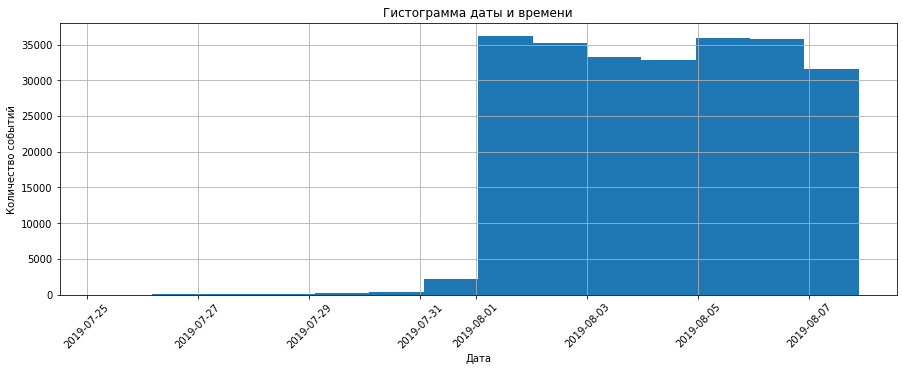

In [14]:
# Построим наглядную гистограмму
plt.figure(figsize=(15,5))
ax = df['event_timestamp'].hist(bins=df['date'].nunique())
plt.title('Гистограмма даты и времени')
plt.ylabel("Количество событий")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.show()

Основная масса данных - записи второй из двух исследуемых недель.<br>
Принимаем решение отказаться от данных первой недели (мало данных), сосредоточимся только на неделе 01 - 07 августа 2019.

In [15]:
# Отфильтруем данные
df_clean = df.loc[df['date'] > '2019-07-31'].reset_index(drop=True)

# Проверим результат
df_clean.sort_values(by='event_timestamp')

,event_name,user_id,event_timestamp,exp_id,date_time,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07
240883,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07
240884,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07
240885,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07


Супер, теперь проверим, сколько событий и пользователей мы потеряли, отбросив старые данные.

In [16]:
# Количество событий
print('Количество оставшихся событий после фильтрации:', df_clean.shape[0])
print('% оставшихся событий после фильтрации:', round(df_clean.shape[0]/df.shape[0]*100, 2))

print()

# Количество уникальных пользователей
print('Количество оставшихся пользователей после фильтрации:', len(df_clean['user_id'].unique()))
print('% оставшихся пользователей после фильтрации:', round(df_clean['user_id'].nunique()/df['user_id'].nunique()*100, 2))

Количество оставшихся событий после фильтрации: 240887
% оставшихся событий после фильтрации: 98.84

Количество оставшихся пользователей после фильтрации: 7534
% оставшихся пользователей после фильтрации: 99.77


In [17]:
# Убедимся, что у нас есть пользователи из всех трёх экспериментальных групп
df_clean.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


**Вывод по изучению данных** <br>

Что мы выяснили:

 - изначально в логе было сохранено 243713 событий и 7551 пользователей,
 - исходный период данных находился в промежутке с 2019-07-25 04:43:36 до 2019-08-07 21:15:17,
 - основная масса данных - записи второй из двух исследуемых недель, поэтому мы отказались от данных первой недели (мало данных) и сосредоточились на неделе 01 - 07 августа 2019,
 - после фильтрации данных мы лишились только 1.16% от первоначального количества событий и 0.23% от первоначального количества пользователей, что совсем немного, 
 - данные о пользователях присутствуют во всех трёх экспериментальных группах.

Переходим к изучению воронки событий.

### Изучение воронки событий

**Посмотрим, какие события есть в логах и как часто они встречаются**

In [18]:
# Отсортируем события по частоте
df_clean['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

**Пользователи и события**

In [19]:
# Выясним, сколько пользователей совершали каждое из этих событий и отсортируем события по числу пользователей
users_events_funnel = df_clean.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})

# Посчитаем долю пользователей, которые хоть раз совершали событие.
users_events_funnel['percent'] = (users_events_funnel['total_users'] / df_clean['user_id'].nunique() * 100).round(2)

users_events_funnel

,event_name,total_users,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Всего в наших записях 5 уникальных событий, в порядке популярности:

 - MainScreenAppear - Главный экран,
 - OffersScreenAppear - Экран предложения покупки,
 - CartScreenAppear - Экран корзины заказа,
 - PaymentScreenSuccessful - Экран успешного платежа,
 - Tutorial - Руководство пользователя.
<br>

В целом, популярность действий логично выстраивается в воронку: сначала пользователь видит основной экран, затем экран с предложением покупки, далее переходит в корзину, а в конце - экран успешной оплаты.<br>

Только событие Tutorial - просмотр страницы обучения использования приложения - не связано с логикой событий.
Значит, Tutorial не нужно учитывать при расчёте воронки.

Для наглядности посмотрим то же самое на графике.

In [20]:
# Исключим событие Tutorial
users_events_funnel = users_events_funnel.query('event_name != "Tutorial"')

users_events_funnel

,event_name,total_users,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


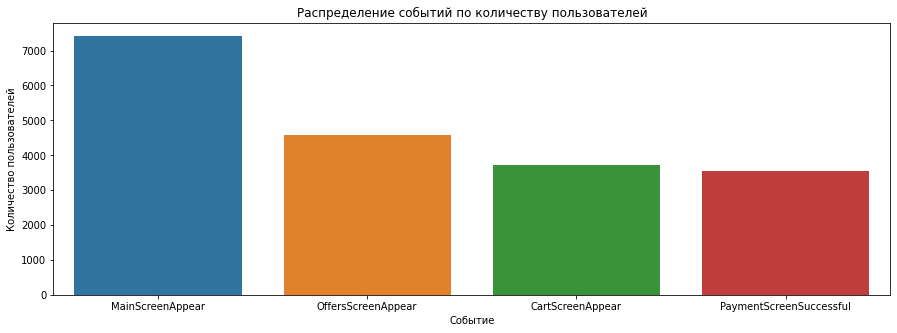

In [21]:
# Построим новую столбчатую диаграмму 
plt.figure(figsize=(15,5))
sns.barplot(x='event_name', y='total_users', data=users_events_funnel)
plt.title('Распределение событий по количеству пользователей')
plt.xlabel('Событие')
plt.ylabel('Количество пользователей')

plt.show()

**Какая доля пользователей проходит на следующий шаг воронки**
(от числа пользователей на предыдущем)

То есть для последовательности событий A → B → C посчитаем:<br>
 - отношение числа пользователей с событием B к количеству пользователей с событием A, а также <br>
 - отношение числа пользователей с событием C к количеству пользователей с событием B.

In [22]:
# Добавим столбец funnel - процент пользователей, перешедших на следующий шаг по отношению к предыдущему кол-ву пользователей
users_events_funnel['funnel'] = 1
for i in range(1, 4):
    users_events_funnel.loc[i, 'funnel']=users_events_funnel.loc[i, 'total_users'] / (users_events_funnel.loc[i-1, 'total_users'])

# Настроим отображение дробных чисел с двумя знаками после точки
pd.options.display.float_format='{:,.2f}'.format

users_events_funnel

,event_name,total_users,percent,funnel
0,MainScreenAppear,7419,98.47,1.00
1,OffersScreenAppear,4593,60.96,0.62
2,CartScreenAppear,3734,49.56,0.81
3,PaymentScreenSuccessful,3539,46.97,0.95


Самый большой разрыв в посещаемости - между главной страницей и страницей предложений - 38% пользователей отсеиваются на этом шаге. <br>
На следующих шагах ситуация лучше - теряются всего 19% (между страницей предложений и корзиной), и 5% пользователей (от корзины до успешной оплаты).<br>

До успешной оплаты и, соответственно, завершения покупки доходят лишь 47% пользователей приложения.

Интересно, что и первый шаг воронки - просмотр главной страницы - совершают не 100% пользователей.<br>
Вероятно, на главную страницу заходить не обязательно. 

**Вывод по изучению воронки событий**

*Всего в наших записях 5 уникальных событий, в порядке популярности:*

 - MainScreenAppear - Главный экран,
 - OffersScreenAppear - Экран предложения покупки,
 - CartScreenAppear - Экран корзины заказа,
 - PaymentScreenSuccessful - Экран успешного платежа,
 - Tutorial - Руководство пользователя.
<br>

В целом, популярность действий логично выстраивается в воронку: сначала пользователь видит основной экран, затем экран с предложением покупки, далее переходит в корзину, а в конце - экран успешной оплаты.<br>

Только событие Tutorial - просмотр страницы обучения использования приложения - не связано с логикой событий.<br>
В дальнейшем мы не будем учитывать Tutorial в расчетах.

*Потери пользователей от шага к шагу выглядят так:*

 - Самый большой разрыв в посещаемости - между главной страницей и страницей предложений: 38% пользователей отсеиваются на этом шаге. Следует проработать этот момент с отделом маркетинга, процент потерь достаточно большой.
 - Далее, между страницей предложений и корзиной, теряются всего 19%, 
 - Затем, от корзины до успешной оплаты, пропадают 5% пользователей.<br>
   Это еще один вопрос коллегам  для проверки: нет ли технических проблем при оплате?

В итоге, до успешного завершения покупки доходят лишь 47% пользователей приложения.

### Изучение результатов эксперимента

**Пользователи в каждой экспериментальной группе**<br>

In [23]:
# Сначала исключим событие Tutorial и сохраним данные в новом датафрейме
df_clean_no_tutorial = df_clean.query('event_name != "Tutorial"')

# Посчитаем, сколько пользователей в каждой экспериментальной группе
AAB_groups = df_clean_no_tutorial.groupby('exp_id')['user_id'].nunique()
AAB_groups

exp_id
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

Как мы знаем, пользователи разделены на три группы: группы 246 и 247 - контрольные, группа 248 - экспериментальная.<br>

В каждой группе примерно равное число участников - около 2.5 тысяч.

**Оценка контрольных экспериментальных групп**<br>
Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.<br>
Проверим, находят ли статистические критерии разницу между контрольными группами 246 и 247.

Вспомним теорию, критерии успешного A/A-теста:
 - Количество пользователей в различных группах различается не более, чем на 1%,
 - Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же,
 - Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости, 
 - Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [24]:
print('Процент совпадения размеров групп 246 и 247:', round(AAB_groups[246]/AAB_groups[247], 3)*100, '%','\n')

Процент совпадения размеров групп 246 и 247: 98.8 % 



Разница между размерами групп чуть больше 1%, будем считать её незначительной в рамках нашего анализа.<br>

Теперь время проверить, есть ли пользователи, попавшие в несколько групп.

In [25]:
# Проверим распределение пользователей по группам
len(df_clean_no_tutorial.groupby('user_id')['exp_id'].nunique().reset_index().query('exp_id > 1')) 

0

Отлично, таких нет.

**Самое популярное событие**<br>

Посчитаем число пользователей, совершивших самое популярное событие в каждой из контрольных групп.<br>

In [26]:
df_clean_no_tutorial.pivot_table(
    index='event_name', columns='exp_id', values='user_id', aggfunc='nunique'
                                ).sort_values(by=[246], ascending=False)

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


Самое популярное событие во всех группах - просмотр главной страницы.<br>
Для группы 246 количество этого события практически равно количеству пользователей.<br>
Соответственно, меньше всего во всех группах событий успешной оплаты.

**Проверим, будет ли отличие между группами статистически достоверным.**

Создадим функцию для подсчёта статистической значимости между группами.

Сформулируем гипотезы:

  - H0 - Между долями нет значимой разницы,
  - H1 - Между долями есть значимая разница.

Пороговое значение alpha примем за 5%.

In [27]:
def ab_calc(df_clean_no_tutorial, group_ids, alpha):
    
    # Вычислим уникальных пользователей в каждой группе
    users = [df_clean_no_tutorial.query('exp_id == @group_id')['user_id'].nunique() for group_id in group_ids]
    
    # Переберём все экспериментальные группы для каждого события, посчитаем количество пользователей и их долю
    for event in df_clean_no_tutorial.event_name.unique():
        events = [df_clean_no_tutorial.query('exp_id == %d and event_name == "%s"' % (group_id, event))['user_id'].nunique() for group_id in group_ids]
        
        # Cравним количество уникальных пользователей на каждом шаге группы с общим количеством уникальных пользователей в этой группе
        p1 = events[0] / users[0] # посчитаем долю для 1 группы
        p2 = events[1] / users[1] # посчитаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        # Вычислим разницу в датасетах
        difference = p1 - p2
        
        # Посчитаем z-value
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1])
        )
        
        # Посчитаем распределение и p-value
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print(event)
        print(p1, p2)
        print('p_value: ', p_value)
        
        # Наконец, сравним значения p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу для события %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу для события %s: нет значимой разницы' % (event))
            
            print(' ')

Сначала проводим A/A тестирование для проверки корректности проведения всего эксперимента.

In [28]:
# Посмотрим на события в 246 и 247 группах
ab_calc(df_clean_no_tutorial, [246, 247], 0.05)

MainScreenAppear
0.9867096254530809 0.9856687898089171
p_value:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.6210229561014902 0.6050955414012739
p_value:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.5098670962545309 0.4928343949044586
p_value:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4832863471606927 0.4609872611464968
p_value:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


Супер! Для контрольных групп 246 и 247, различия по всем событиям статистически не значимы.<br>

Теперь мы можем продолжить А/В-анализ любой из контрольных групп 246 и 247 с экспериментальной группой 248.

**Сравним результаты с каждой из контрольных групп в отдельности по каждому событию**

In [29]:
# Начнем с 246 и 248 групп
ab_calc(df_clean_no_tutorial, [246, 248], 0.05)

MainScreenAppear
0.9867096254530809 0.9834319526627219
p_value:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.6210229561014902 0.6039447731755424
p_value:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.5098670962545309 0.48520710059171596
p_value:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4832863471606927 0.4658777120315582
p_value:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


Для групп 246 и 248 различия по всем событиям статистически не значимы.

In [30]:
# Теперь посмотрим на события в 247 и 248 группах
ab_calc(df_clean_no_tutorial, [247, 248], 0.05)

MainScreenAppear
0.9856687898089171 0.9834319526627219
p_value:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.6050955414012739 0.6039447731755424
p_value:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.4928343949044586 0.48520710059171596
p_value:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4609872611464968 0.4658777120315582
p_value:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


Аналогично, для групп 247 и 248 различия по всем событиям статистически не значимы.

In [31]:
# Добавим контрольную группу 247 к группе 246 и сохраним эту общую группу под номером 246
df_clean_no_tutorial_AA_combo = df_clean_no_tutorial.copy()
df_clean_no_tutorial_AA_combo["exp_id"].replace({247: 246}, inplace=True)
df_clean_no_tutorial_AA_combo["exp_id"].value_counts()

246    155669
248     84213
Name: exp_id, dtype: int64

In [32]:
# Теперь посмотрим на события в объединённой 246 группе и экспериментальной 248-ой
ab_calc(df_clean_no_tutorial_AA_combo, [246, 248], 0.05)

MainScreenAppear
0.9861861861861861 0.9834319526627219
p_value:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.613013013013013 0.6039447731755424
p_value:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.5013013013013013 0.48520710059171596
p_value:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4720720720720721 0.4658777120315582
p_value:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


И снова различия по всем событиям двух групп статистически не значимы.

**Промежуточный вывод**

При проведении z-теста гипотеза о равенстве групп ни разу не была отвергнута (в том числе и для группы, состоящей из суммы тестовых групп).

Но есть нюанс: мы провели целых 16 тестов, а при таком количестве возникает вероятность ложноположительного результата.<br>

Чтобы групповая вероятность ошибки в данном случае не превышала определенный уровень значимости α (в нашем случае - 0.05), нам будет нужно сравнить каждое из полученных p-value не с α, а с α / m (где m - число проверяемых гипотез), согласно поправке Бонферрони. 

Для этого поделим принятый ранее уровень значимости 0.05 на число сравнений 16.<br>
Итак, новое значение α для наших тестов будет 0.05 / 16 = 0.003.

**Тесты после внесения поправки Бонферрони**

Сформулируем гипотезы:

 - Н0 - различия между экспериментальными группами статистически не значимы (статистически значимой разницы нет),

 - Н1 - различия между экспериментальными группами статистически значимы (статистически значимая разница есть).

Пороговое значение alpha примем за 0.3%.

In [33]:
# Начнем с 246 и 248 групп
ab_calc(df_clean_no_tutorial, [246, 248], 0.003)

MainScreenAppear
0.9867096254530809 0.9834319526627219
p_value:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.6210229561014902 0.6039447731755424
p_value:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.5098670962545309 0.48520710059171596
p_value:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4832863471606927 0.4658777120315582
p_value:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


Для групп 246 и 248 различия по всем событиям статистически не значимы.

In [34]:
# Продолжим с группами 247 и 248
ab_calc(df_clean_no_tutorial, [247, 248], 0.003)

MainScreenAppear
0.9856687898089171 0.9834319526627219
p_value:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.6050955414012739 0.6039447731755424
p_value:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.4928343949044586 0.48520710059171596
p_value:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4609872611464968 0.4658777120315582
p_value:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


Для групп 247 и 248 различия по всем событиям статистически не значимы.

In [35]:
# Теперь посмотрим на события в объединённой 246 группе и экспериментальной 248-ой
ab_calc(df_clean_no_tutorial_AA_combo, [246, 248], 0.003)

MainScreenAppear
0.9861861861861861 0.9834319526627219
p_value:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear: нет значимой разницы
 
OffersScreenAppear
0.613013013013013 0.6039447731755424
p_value:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear: нет значимой разницы
 
CartScreenAppear
0.5013013013013013 0.48520710059171596
p_value:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear: нет значимой разницы
 
PaymentScreenSuccessful
0.4720720720720721 0.4658777120315582
p_value:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful: нет значимой разницы
 


Для объединенной группы 246 и экспериментальной 248 различия по всем событиям статистически не значимы.

После всех тестов с учётом нашей поправки порогового значения alpha по-прежнему нет оснований отвергнуть нулевую гипотезу.

**Вывод по изучению результатов эксперимента**

В нашем эксперименте пользователи разделены на три группы: группы 246 и 247 - контрольные, группа 248 - экспериментальная.<br>
В каждой группе примерно равное число участников - около 2.5 тысяч.

Тестируемые группы соответствуют условиям корректного тестирования, и отличия между всеми группами незначительны (1-2%).<br> 
Пользователей, попавших в несколько групп, мы не нашли.<br>
В итоге, данные групп считаем корректными для анализа.

Для проверки достоверности отличий между группами мы создали функцию подсчёта статистической значимости между группами и сформулировали гипотезы:

 - Н0 - различия между экспериментальными группами статистически не значимы (статистически значимой разницы нет),

 - Н1 - различия между экспериментальными группами статистически значимы (статистически значимая разница есть).

Пороговое значение alpha приняли за 5%.

При проведении z-теста гипотеза о равенстве групп ни разу не была отвергнута (в том числе и для группы, состоящей из суммы тестовых групп).<br>
Мы провели целых 16 тестов, и, чтобы исключить вероятность ложноположительного результата, скорректировали уровень значимости 
до 0.003 согласно поправке Бонферрони.

После всех тестов с учётом поправки порогового значения alpha по-прежнему нет оснований отвергнуть нулевую гипотезу.

### Общий вывод

Напомним, что наши данные для анализа это лог, где каждая запись - действие пользователя мобильного приложения.<br>
Действия разделены на 3 группы: 2 контрольные и одна экспериментальная (для её пользователей был изменен шрифт приложения).<br>

У нас было 2 задачи: 
 - Разобраться, как ведут себя пользователи нашего мобильного приложения,
 - Понять, изменилась ли конверсия в тестовой группе в связи с новым шрифтом приложения.

*Перед работой с данными мы провели предобработку, а при изучении данных выяснили, что:*
 - Изначально в логе было сохранено более 240000 событий и более **7500 пользователей**, что достаточно много для проведения анализа,
 - Исходный период данных находился в промежутке с 25 июля 2019 по 07 августа 2019, но основная масса данных - записи второй из двух исследуемых недель, поэтому мы отказались от данных первой недели (мало данных) и сосредоточились **на неделе 01 - 07 августа 2019**,
 - Данные о пользователях присутствуют во всех трёх экспериментальных группах.
 
*После изучения воронки событий мы узнали, что:*

- Всего в наших записях 5 уникальных событий, самое популярное - просмотр Главного экрана приложения,
- Популярность действий соответсвует логике взаимодействия с приложением: сначала пользователь видит основной экран, затем экран с предложением покупки, далее переходит в корзину, а в конце - экран успешной оплаты.

- Потери пользователей от шага к шагу выглядят так:
  - Самый большой разрыв посещаемости - **между главной страницей и страницей предложений: теряем 38% пользователей** на этом шаге,
  - Далее, между страницей предложений и корзиной, отсеиваются 19%,
  - Затем, от корзины до успешной оплаты, пропадают 5% пользователей.<br>

В итоге, **до успешного завершения покупки доходят лишь 47%** от первоначального количества пользователей приложения.

*После изучения результатов эксперимента:*

 - В нашем эксперименте пользователи разделены на три группы: 2 контрольные, и одна группа - экспериментальная.<br>
 - В каждой группе примерно равное число участников - около 2.5 тысяч.
 - Данные групп мы оцниваем как корректные для проведения анализа.

 - После проведения z-теста мы полагаем, что статистически значимой разницы между группами нет, гипотеза об отсутствии различий между конверсиями событий тестируемых групп не опровергнута.

Другими словами, разницы между поведением пользователей до изменения шрифта приложения и после с большой долей вероятности нет.<br>
**Можно поменять шрифт или оставить прежний вариант**, вероятность влияния этого изменения на конверсию не подтверждена.

*Завершая вывод, предлагаем пару идей коллегам из отдела маркетинга:*
 - Процент потерь пользователей при переходе с главной страницы на страницу предложений: 38% пользователей отсеиваются на этом шаге, следует изучить этот вопрос подробнее.
 - Также, **в шаге от корзины до успешной оплаты пропадают 5% пользователей**.<br>
   Возможно, есть технические проблемы при оплате.